# Text Sentiment Analysis
When was the last time you checked the Amazon reviews of a product before buying it?

Have you used Twitter or Facebook to comment on how good or how bad it was?

This kind of data is extremely valuable to the companies who sell the product and also to social media organisations to detect toxic comments.

Natural language processing is one of the most popular applications of machine learning and deep learning. Since a majority of the data is actually unstructured, Natural language processing is necessary to understand it.

* Sentiment Analysis and Text classification are one of the initial tasks you will come across in your Natural language processing Journey.
* This Sentiment Analysis course is designed to give you hands-on experience in solving a sentiment analysis problem using Python.
* This course will also introduce you to the skills and techniques required to solve text classification/sentiment analysis problems.
* Sentiment Analysis itself is further used in chatbots, business intelligence, and in many more domains.

## Content
1. Understand the Problem Statement 
2. Tweets Preprocessing and Cleaning 
    * Data Inspection
    * Data Cleaning 
3. Story Generation and Visualization from Tweets 
4. Extracting Features from Cleaned Tweets 
    * Bag-of-Words 
    * TF-IDF 
    * Word Embeddings 
5. Model Building: Sentiment Analysis
    * Logistic Regression
    * Support Vector Machine 
    * RandomForest 
    * XGBoost 
6. Model Fine-tuning 
7. Summary 

## Problem Statement
The objective of this task is to **detect hate speech** in tweets. For the sake of simplicity we say a tweet contains hate speech if it has a racist or sexist sentiments associated with it. So the task is **given a tweet classify it as racist/sexist or non racist/sexist**.
<br>The evaluation metric is F1 score.</br>

In [50]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import string
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
# Load train and test dataset
train = pd.read_csv("./Datasets/train.csv")
test = pd.read_csv("./Datasets/test.csv")

## Tweets Preprocessing and Cleaning
### Data Inspection
Let us check some racist and non racist tweets

In [3]:
# Check racist tweets
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [4]:
# Check non racist tweets
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [5]:
# Check dimensionality 
train.shape, test.shape

((31962, 3), (17197, 2))

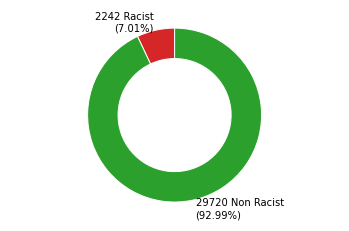

In [6]:
# Label Distribution
train_non_racist_percent = round(train["label"].value_counts()[0] / train.shape[0] * 100)
train_racist_percent = round(train["label"].value_counts()[1] / train.shape[0] * 100)

labels = 'Racist', 'Non Racist'
sizes = train["label"].value_counts()[1], train["label"].value_counts()[0]
pcts = [f'{s} {l}\n({s*100/sum(sizes):.2f}%)' for s,l in zip(sizes, labels)]
width = 0.35

_, ax = plt.subplots()
ax.axis('equal')

pie, _ = ax.pie(
    sizes,
    startangle=90,
    labels=pcts,
    colors = ["tab:red", "tab:green"]
)

plt.setp(pie, width=width, edgecolor='white')

plt.show()

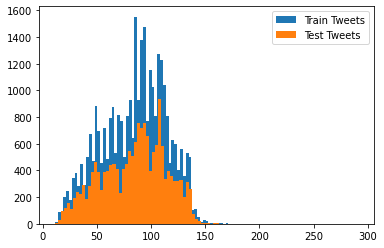

In [7]:
# Distribution of tweets based on the length of words
len_train = train['tweet'].str.len()
len_test = test['tweet'].str.len()

plt.hist(len_train, bins = 100, label = 'Train Tweets')
plt.hist(len_test, bins = 100, label = 'Test Tweets')
plt.legend()
plt.show()

The distribution of tweets length in both train and test data looks similar.

### Data Cleaning

In [8]:
# Combine train and test data, it would make pre processing of data easier
combi  = train.append(test, ignore_index = True)
combi.shape

(49159, 3)

In [9]:
# user defined function to remove unwanted text pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

In [10]:
# Remove Twitter Handles
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

# Remove Punctuation, Number and Special Characters
# Replace everything expect character, hastag with space
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

# Remove short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# Text Tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

# Text Normalization - Stemming
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

# Stick these tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet

## Story Generation and Tweets Visualization

1. What are the most common words in datasets ?
2. What are the most common words in positive and negative tweets ?
3. How many hashtag are there in tweets ?
4. Which trend is associated with my dataset ?
5. Which trend is associated with either of the sentiments ?

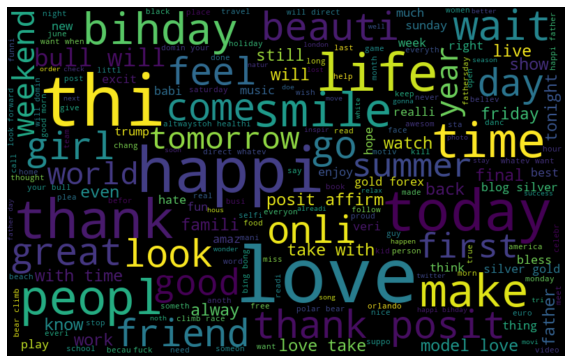

In [11]:
# Word cloud

all_words = ' '.join([text for text in combi['tidy_tweet']])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

We can see most common words like love, friend, happy are related to positive sentiments. Lets build wordcloud for each of the label

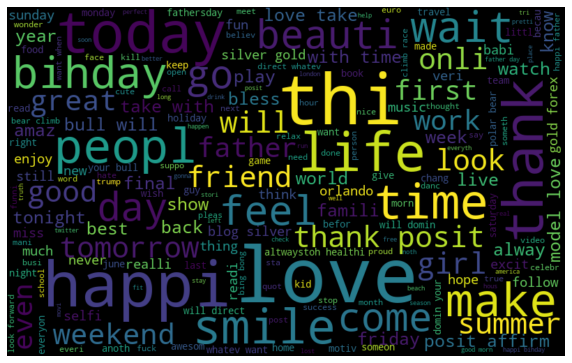

In [12]:
# Wordcloud in non racist/sexist tweets

normal_words = ' '.join([text for text in combi[combi['label'] == 0]['tidy_tweet']])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(normal_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

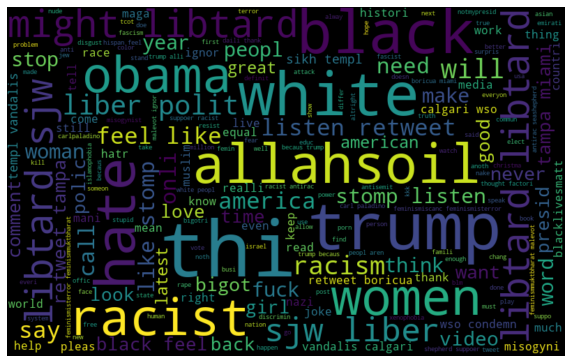

In [13]:
# Wordcloud in racist/sexist tweets

racist_word = ' '.join([text for text in combi[combi['label'] == 1]['tidy_tweet']])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(racist_word)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

we can clearly see there are lot of words with negative meaning.

#### Understand Hashtag on tweets sentiments
Hashtag are synonymous with the ongoing trends on twitter. Usually the sentiment of tweets are similar to the hastags they have.

In [14]:
# functions to collect hastags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [15]:
combi[combi['label'] == 0]['tidy_tweet']

0                                          when father dysfunct selfish drag kid into dysfunct #run
1                            thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2                                                                               bihday your majesti
3                                                                        #model love take with time
4                                                                          factsguid societi #motiv
                                                    ...                                            
31956                                                      fish tomorrow carnt wait first time year
31957                                                                                    that youuu
31958    nina turner airwav tri wrap herself mantl genuin hero like shirley chisolm #shame #imwithh
31959                                                                  listen song monday morn work


In [16]:
# Extract hastags from non racist tweets
ht_regular = hashtag_extract(combi[combi['label'] == 0]['tidy_tweet'])

# Extract hastags from racist tweets
ht_racist = hashtag_extract(combi[combi['label'] == 1]['tidy_tweet'])

# unnesting list
ht_regular = sum(ht_regular, [])
ht_racist = sum(ht_racist, [])

#### Non Racist Hashtags 

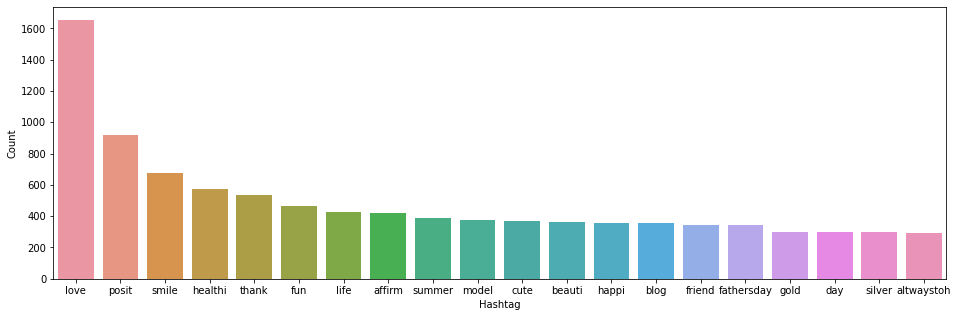

In [17]:
a = nltk.FreqDist(ht_regular)
d = pd.DataFrame({"Hashtag": list(a.keys()), 
                 'Count': list(a.values())})

# select top 20 hastags
d = d.nlargest(columns = "Count", n = 20)
plt.figure(figsize = (16, 5))
ax = sns.barplot(data = d, x = "Hashtag", y = "Count")
ax.set(ylabel = "Count")
plt.show()

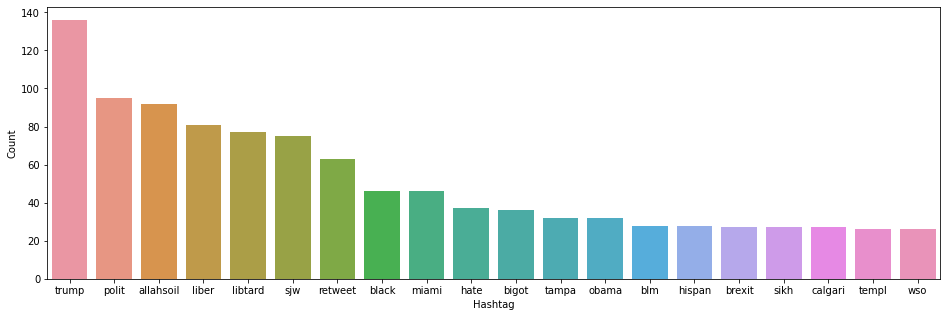

In [18]:
b = nltk.FreqDist(ht_racist)
e = pd.DataFrame({"Hashtag": list(b.keys()), 
                 'Count': list(b.values())})

# select top 20 hastags
e = e.nlargest(columns = "Count", n = 20)
plt.figure(figsize = (16, 5))
ax = sns.barplot(data = e, x = "Hashtag", y = "Count")
ax.set(ylabel = "Count")
plt.show()

## Extracting Features from Cleaned Tweets
### Bag of Words Feature
To analyze preprocessed data, it need to be converted into features. Depending upon the usage, text features can be constructed into assorted techniques - BOW, TF-ITF, Word Embeddings

In [19]:
#  A max_df of 0.9 means "ignore terms that appear in more than 90% of the tweets".
bow_vectorizer = CountVectorizer(max_df = 0.9, min_df = 2, max_features = 1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [20]:
bow.shape

(49159, 1000)

### TF-TDF

It takes into account not just the occurance of words in a single document (tweet) but in the entire corpus.
TF-TDF work by penalising the common words by assigning lower weights while importance to the words which are rare in the entire corpus.

1. TF = Number of times the term t appear in the document / number of terms in that document
2. IDF = log(N/n) where N is the number of documents and n is the number of documents a term t has appeared in 
3. TFIDF = IF * IDF

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

### Word Embedding
Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus. They are able to achieve tasks like King -man +woman = Queen

The advantages of using word embeddings over BOW or TF-IDF are: 
1. Dimensionality reduction - significant reduction in the no. of features required to build a model. 
2. It capture meanings of the words, semantic relationships and the different types of contexts they are used in. 

#### word2vec

In [22]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_tweet,
                                  size = 200,   # number of features
                                  window = 5,
                                  min_count = 2,
                                  sg = 1,
                                  hs = 0, 
                                  negative = 10, 
                                  workers = 2,
                                  seed = 34) 
model_w2v.train(tokenized_tweet, total_examples = len(combi['tidy_tweet']), epochs = 20)

(6510028, 7536020)

In [23]:
model_w2v.wv.most_similar(positive = 'dinner')

[('#avocado', 0.5619504451751709),
 ('spaghetti', 0.5528597235679626),
 ('cookout', 0.5528173446655273),
 ('#biall', 0.5435267686843872),
 ('#cellar', 0.5398961901664734),
 ('fav', 0.5397176742553711),
 ('melani', 0.5382366180419922),
 ('spinach', 0.5376657247543335),
 ('#bihdaydinn', 0.5347098112106323),
 ('noodl', 0.5327069163322449)]

#### Prepare Vectors for Tweets
Since our data contains tweets and not just words, we'll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data. 

In [51]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1
        except KeyError: # handling the case where the token in not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [25]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

### Doc2Vec

In [53]:
from tqdm import tqdm
tqdm.pandas(desc = "progress-bar")

from gensim.models.doc2vec import LabeledSentence

C:\Users\91798\Anaconda3\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim's LabeledSentence() function. 

In [54]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [55]:
labeled_tweets = add_label(tokenized_tweet)
labeled_tweets[:6]

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talk', 'befor', 'they', 'leav', 'chao', 'disput', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [58]:
model_d2v = gensim.models.Doc2Vec(dm = 1, dm_mean=1, size = 200, window = 5, negative = 7, min_count = 5, workers = 3, 
                                 alpha = 0.1,
                                 seed = 23)
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])
model_d2v.train(labeled_tweets, total_examples = len(combi['tidy_tweet']), epochs = 15)

C:\Users\91798\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|███████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 3526386.02it/s]


In [59]:
# Preparing doc2vec Feature Set
docvec_arrays = np.zeros((len(tokenized_tweet), 200))
for i in range(len(combi)):
    docvec_arrays[i, :] = model_d2v.docvecs[i].reshape((1, 200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

## Modelling
### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

#### BOW


In [27]:
train_bow = bow[:31962]
test_bow = bow[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_bow, train['label'], random_state = 42)

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_prediction = lr.predict_proba(X_valid)
lr_predict = lr.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, lr_predict))
print("F1 score: ", f1_score(y_valid, lr_predict))

Accuracy:  0.9474408709798523
F1 score:  0.5047169811320754


#### TFIDF

In [28]:
train_tfidf = tfidf[:31962]
test_tfidf = tfidf[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_tfidf, train['label'], random_state = 42)

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_prediction = lr.predict_proba(X_valid)
lr_predict = lr.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, lr_predict))
print("F1 score: ", f1_score(y_valid, lr_predict))

Accuracy:  0.9479414341133775
F1 score:  0.4720812182741117


#### Word2Vec

In [29]:
train_w2v = wordvec_df.values[:31962]
test_w2v = wordvec_df.values[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_w2v, train['label'], random_state = 42)

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_prediction = lr.predict_proba(X_valid)
lr_predict = lr.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, lr_predict))
print("F1 score: ", f1_score(y_valid, lr_predict))

Accuracy:  0.9495682642973345
F1 score:  0.5662002152852529


#### Doc2Vec

In [62]:
train_d2v = docvec_df.values[:31962]
test_d2v = docvec_df.values[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_d2v, train['label'], random_state = 42)

lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train,y_train)
lr_prediction = lr.predict_proba(X_valid)
lr_predict = lr.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, lr_predict))
print("F1 score: ", f1_score(y_valid, lr_predict))

Accuracy:  0.9322988361907145
F1 score:  0.27576974564926376


### SVM
#### BOW

In [30]:
from sklearn import svm

In [31]:
train_bow = bow[:31962]
test_bow = bow[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_bow, train['label'], random_state = 42)

svm = svm.SVC(kernel = 'linear', C = 1, probability = True)
svm.fit(X_train,y_train)
svm_prediction = svm.predict_proba(X_valid)
svm_predict = svm.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, svm_predict))
print("F1 score: ", f1_score(y_valid, svm_predict))

Accuracy:  0.9475660117632336
F1 score:  0.4945717732207479


#### Word2Vec

In [32]:
# train_w2v = wordvec_df.values[:31962]
# test_w2v = wordvec_df.values[31962:]

# X_train, X_valid, y_train, y_valid = train_test_split(train_w2v, train['label'], random_state = 42)

# clf_svm = svm.SVC(kernel = 'linear', C = 1, probability = True)
# clf_svm.fit(X_train,y_train)
# svm_prediction = clf_svm.predict_proba(X_valid)
# svm_predict = clf_svm.predict(X_valid)
# print("Accuracy: ", accuracy_score(y_valid, svm_predict))
# print("F1 score: ", f1_score(y_valid, svm_predict))

### Random Forest
#### Word2Vec

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
train_w2v = wordvec_df.values[:31962]
test_w2v = wordvec_df.values[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_w2v, train['label'], random_state = 42)

clf_rf = RandomForestClassifier(n_estimators = 400, random_state = 11)
clf_rf.fit(X_train,y_train)
rf_prediction = clf_rf.predict_proba(X_valid)
rf_predict = clf_rf.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, rf_predict))
print("F1 score: ", f1_score(y_valid, rf_predict))

Accuracy:  0.9545738956325867
F1 score:  0.5340179717586648


### XGBoost Hyperparameter Tuning + Word2Vec
Extreme Gradient Boosting (xgboost) is an advanced implementation of gradient boosting algorithm. It has both linear model solver and tree learning algorithms. Its ability to do parallel computation on a single machine makes it extremely fast. It also has additional features for doing cross validation and finding important variables. There are many parameters which need to be controlled to optimize the model. 
Some key benefits of XGBoost are: 
1. Regularization - helps in reducing overfitting 
2. Parallel Processing - XGBoost implements parallel processing and is blazingly faster as compared to GBM. 
3. Handling Missing Values - It has an in-built routine to handle missing values. 
4. Built-in Cross-Validation - allows user to run a cross-validation at each iteration of the boosting process 


In [35]:
import xgboost as xgb

In [36]:
train_w2v = wordvec_df.values[:31962]
test_w2v = wordvec_df.values[31962:]

X_train, X_valid, y_train, y_valid = train_test_split(train_w2v, train['label'], random_state = 42)

# DMatrices contains both feature and target
dtrain = xgb.DMatrix(X_train, label = y_train)
dvalid = xgb.DMatrix(X_valid, label = y_valid)
dtest = xgb.DMatrix(test_w2v)

# Parameter that we are going to tune
params = {'objective': 'binary:logistic',
        'max_depth': 6,
        'min_child_weight': 1,
        'eta': 0.3,
        'subsample': 1,
        'colsample_bytree': 1}

In [37]:
# Function to calculate F1 score
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds > 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

In [38]:
# Hyperparameter Tuning - max_depth and min_child_weight
gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(6, 10) for min_child_weight in range(5, 8)]

max_f1 = 0
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV for max_depth = {}, min_child_weight = {}".format(max_depth, min_child_weight))
    
    # Update our parameter
    params['max_depth'] = max_depth
    params['min_child_weights'] = min_child_weight
    
    # Cross Validation
    cv_results = xgb.cv(params, dtrain,
                       feval = custom_eval,
                       num_boost_round =200,
                       maximize = True,
                       seed = 16, 
                       nfold = 5,
                       early_stopping_rounds = 2)

CV for max_depth = 6, min_child_weight = 5
[18:59:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may 

[19:02:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:02:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:02:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are 

[19:04:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:04:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:04:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are 

In [39]:
# Finding best F1_score
mean_f1 = cv_results['test-f1_score-mean'].max()

boost_rounds = cv_results['test-f1_score-mean'].argmax()
print("\tF1 score {} for {} rounds".format(mean_f1, boost_rounds))
if mean_f1 > max_f1:
    max_f1 = mean_f1
    best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

	F1 score 0.6112782 for 26 rounds
Best params: 9, 7, F1 Score: 0.6112782


In [40]:
# Update max_depth and min_child_weight
params['max_depth'] = 9
params['min_child_weight'] = 7

In [41]:
# Tuning subsample and colsample
grid_search_params = [(subsample, colsample) for subsample in [i/10 for i in range(5, 10)]
                     for colsample in [i/10 for i in range(5, 10)]]

In [42]:
max_f1 = 0
best_params = None

for subsample, colsample in grid_search_params:
    print("CV with subsample = {}, colsample = {}".format(subsample, colsample))
    
    # Update our parameter
    params['colsample'] = colsample
    params['subsample'] = subsample
    
    # Cross Validation
    cv_results = xgb.cv(params, dtrain,
                       feval = custom_eval,
                       num_boost_round =200,
                       maximize = True,
                       seed = 16, 
                       nfold = 5,
                       early_stopping_rounds = 2)

CV with subsample = 0.5, colsample = 0.5
[19:06:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:06:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:06:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.5, colsample = 0.9
[19:07:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.6, colsample = 0.8
[19:09:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:09:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:09:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.7, colsample = 0.7
[19:11:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:11:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:11:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.8, colsample = 0.6
[19:13:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:13:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:13:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.9, colsample = 0.5
[19:14:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:14:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

CV with subsample = 0.9, colsample = 0.9
[19:16:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } 

In [43]:
# Finding best F1_score
mean_f1 = cv_results['test-f1_score-mean'].max()

boost_rounds = cv_results['test-f1_score-mean'].argmax()
print("\tF1 score {} for {} rounds".format(mean_f1, boost_rounds))
if mean_f1 > max_f1:
    max_f1 = mean_f1
    best_params = (subsample, colsample)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

	F1 score 0.6129802 for 27 rounds
Best params: 0.9, 0.9, F1 Score: 0.6129802


In [44]:
# Update subsample and colsample
params['subsample'] = 0.8
params['colsample'] = 0.9

In [45]:
# Tune Learning Rate
max_f1 = 0
best_params = None

for eta in [0.3, 0.2, 0.1, 0.05, 0.01, 0.005]:
    print("CV with eta = {}".format(eta))
    
    # Update our parameter
    params['eta'] = eta
    
    # Cross Validation
    cv_results = xgb.cv(params, dtrain,
                       feval = custom_eval,
                       num_boost_round =1000,
                       maximize = True,
                       seed = 16, 
                       nfold = 5,
                       early_stopping_rounds = 3)

CV with eta = 0.3
[19:17:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:17:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:17:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  T

CV with eta = 0.01
[19:21:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:21:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:21:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample, min_child_weights } might not be used.

  

In [46]:
# Finding best F1_score
mean_f1 = cv_results['test-f1_score-mean'].max()

boost_rounds = cv_results['test-f1_score-mean'].argmax()
print("\tF1 score {} for {} rounds".format(mean_f1, boost_rounds))
if mean_f1 > max_f1:
    max_f1 = mean_f1
    best_params = eta

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

	F1 score 0.0 for 0 rounds
Best params: None, F1 Score: 0


In [47]:
params['eta'] = 0.1

In [49]:
# Final model
params = {'objective': 'binary:logistic',
          'max_depth': 9,
          'min_child_weight': 7,
          'eta': 0.1,
          'subsample': 0.9,
          'colsample': 0.9,
          'colsample_bytree': 0.5}

xgb_model = xgb.train(params, dtrain,
                       feval = custom_eval,
                       num_boost_round =1000,
                       maximize = True,
                       evals = [(dvalid, "Validation")],
                       early_stopping_rounds = 10)

[19:23:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Validation-error:0.06195	Validation-f1_score:0.00000
Multiple eval metrics have been passed: 'Validation-f1_score' will be used for early stopping.

Will train until Validation-f1_score hasn't improved in 10 rounds.
[1]	Validation-error:0.05456	Validation-f1_score:0.19677
[2]	Validation-error:0.05356	Validation-f1_score:0.24176
[3]	Validation-error:0.05356	Validation-f1_score:0.27692
[4]	Validation-error:0.05168	Validation-f1_score:0.30723
[5]	Validation-error:0.05131	Validation-f1_score:0.33778
[6]	Validation-error:0.05031	Validation-f1_score:0.35620
[7]	Validation-error:0.04993	Validation-f1_score:0.

[132]	Validation-error:0.03879	Validation-f1_score:0.61806
[133]	Validation-error:0.03917	Validation-f1_score:0.62529
[134]	Validation-error:0.03904	Validation-f1_score:0.62442
[135]	Validation-error:0.03892	Validation-f1_score:0.62687
[136]	Validation-error:0.03917	Validation-f1_score:0.62299
[137]	Validation-error:0.03892	Validation-f1_score:0.62212
[138]	Validation-error:0.03904	Validation-f1_score:0.61734
[139]	Validation-error:0.03892	Validation-f1_score:0.62370
[140]	Validation-error:0.03917	Validation-f1_score:0.62687
[141]	Validation-error:0.03954	Validation-f1_score:0.62844
[142]	Validation-error:0.03917	Validation-f1_score:0.62759
[143]	Validation-error:0.03954	Validation-f1_score:0.63073
[144]	Validation-error:0.03992	Validation-f1_score:0.62916
[145]	Validation-error:0.03992	Validation-f1_score:0.62916
[146]	Validation-error:0.04017	Validation-f1_score:0.63073
[147]	Validation-error:0.04017	Validation-f1_score:0.63146
[148]	Validation-error:0.04042	Validation-f1_score:0.630

In [64]:
# On test data
test_pred = xgb_model.predict(dtest)
test['label'] = (test_pred >= 0.3).astype(np.int)

In [65]:
test

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦,0
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why,0
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!,0
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite",0
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦",0
...,...,...,...
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,1
17193,49156,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,0
17194,49157,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",0
17195,49158,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",0
